In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
df = pd.read_csv('sales_data.csv', parse_dates=['Date'])
print(df.head(),"\n")
print(df.info())

                           Date    Store Region  Product  Units Sold  \
0 2024-05-16 16:58:17.187970304  Store_8  North  Monitor          49   
1 2024-12-13 00:15:26.366943232  Store_3  South   Webcam          17   
2 2024-09-24 04:16:00.948964352  Store_8   East   Laptop          43   
3 2024-08-06 12:14:53.957637632  Store_5  South  Monitor          25   
4 2024-02-26 22:43:23.844992768  Store_1   East   Laptop           3   

   Unit Price       Revenue  
0  356.037854  17445.854831  
1   62.175557   1056.984475  
2  836.320946  35961.800693  
3  356.037854   8900.946342  
4  836.320946   2508.962839   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1000 non-null   datetime64[ns]
 1   Store       1000 non-null   object        
 2   Region      1000 non-null   object        
 3   Product     1000 non-null   object 

In [18]:
region_revenue = df.groupby('Region')['Revenue'].sum().sort_values(ascending=False)
print(region_revenue)

Region
East     2.769335e+06
North    2.717608e+06
South    2.373840e+06
Name: Revenue, dtype: float64


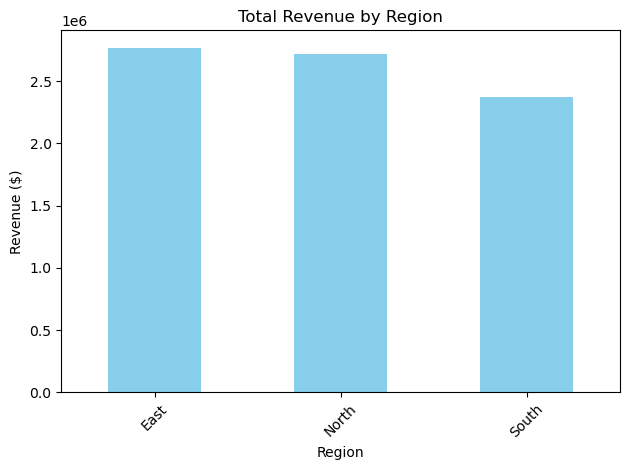

In [19]:
region_revenue.plot(kind='bar', color='skyblue', title='Total Revenue by Region')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

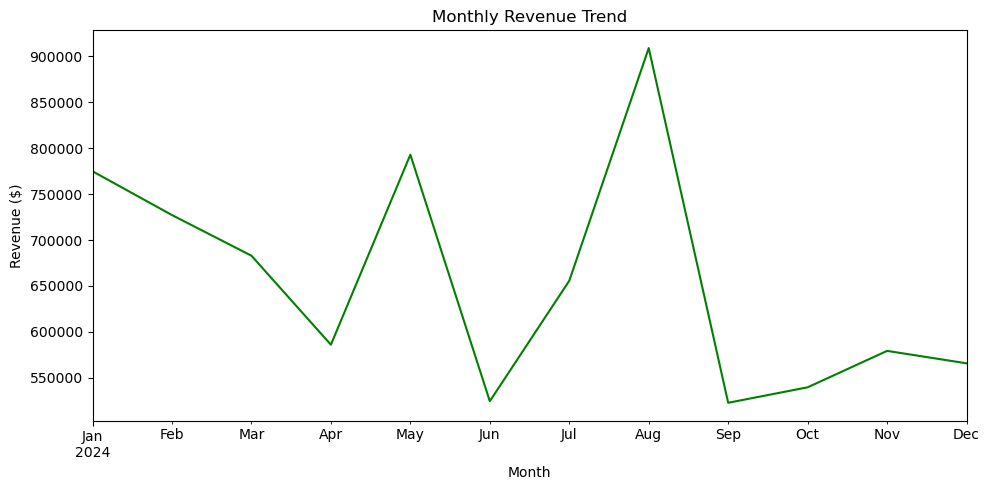

In [24]:
df.set_index('Date', inplace=True)
monthly_revenue = df['Revenue'].resample('ME').sum()
monthly_revenue.plot(title='Monthly Revenue Trend', figsize=(10, 5), color='green')
plt.ylabel('Revenue ($)')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

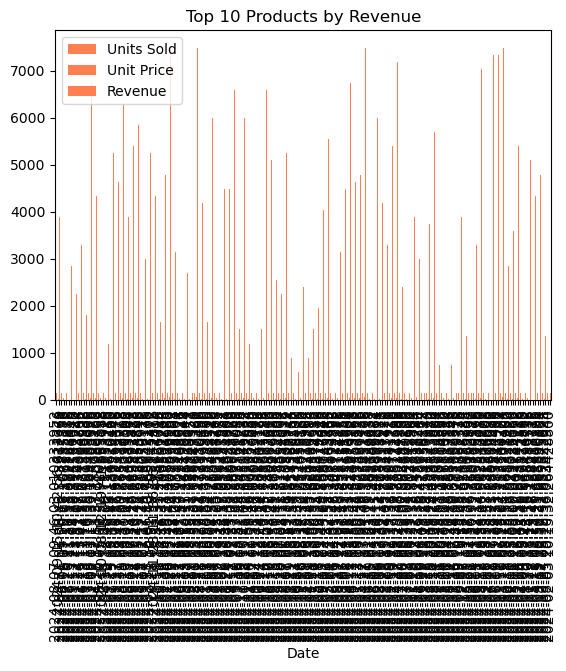

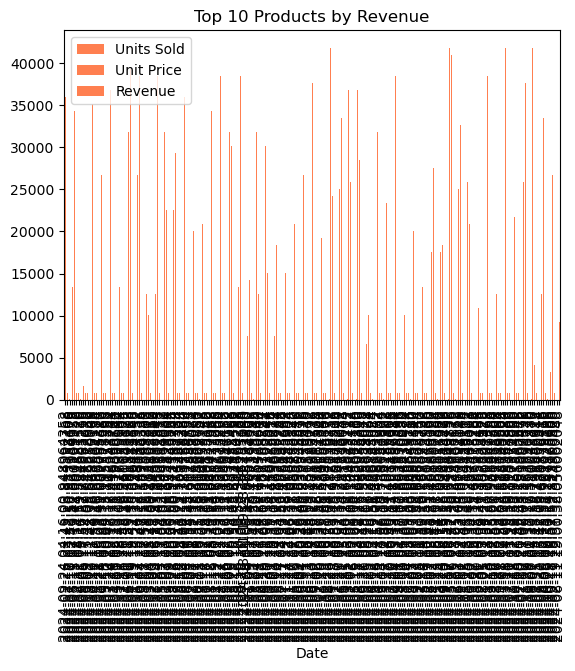

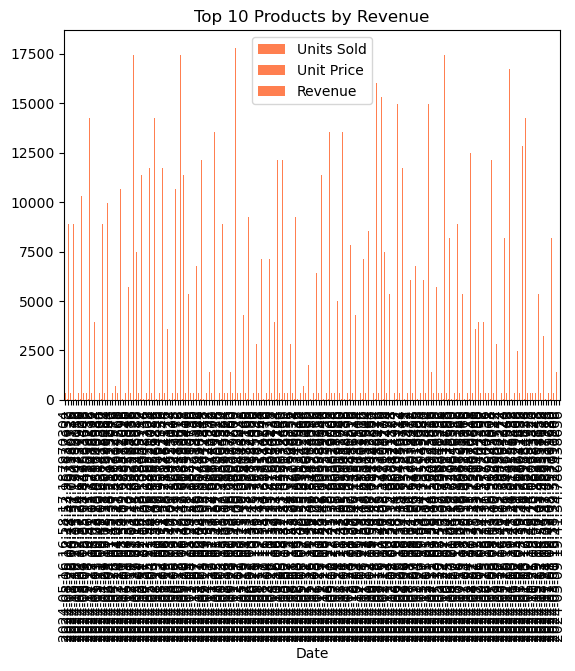

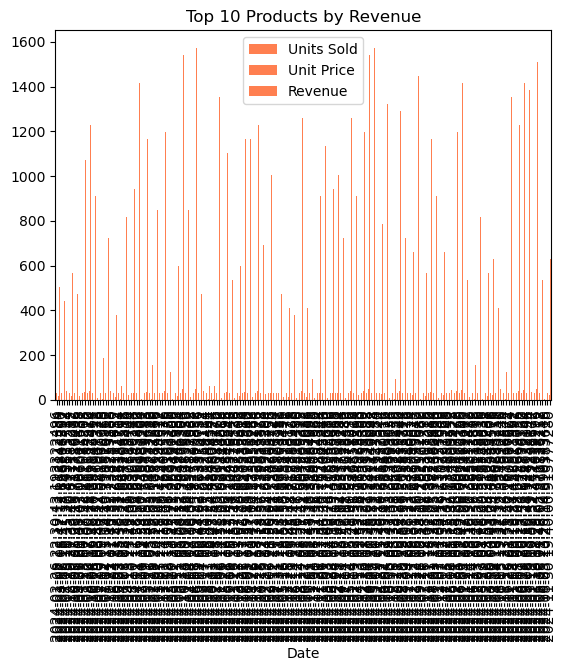

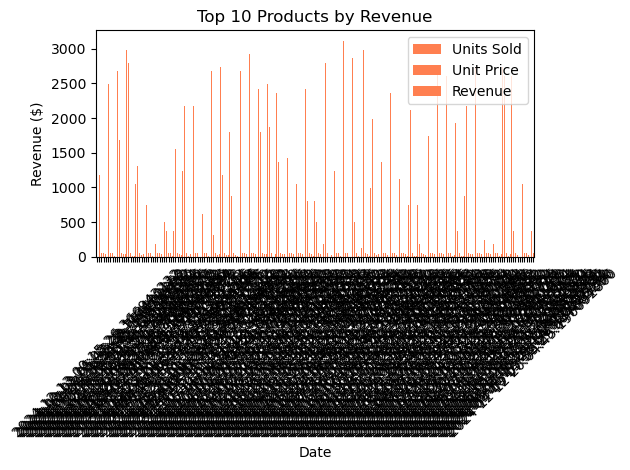

In [41]:
product_revenue = df.groupby('Product')
df['Revenue'].sort_values().sort_values(ascending=False).head(10)
product_revenue.plot(kind='bar', title='Top 10 Products by Revenue', color='coral')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
avg_order_value = df['Revenue'].mean()
avg_unit_price = df['Unit Price'].mean()

print(f"Average Order Value: ${avg_order_value:.2f}")
print(f"Average Unit Price: ${avg_unit_price:.2f}")

Average Order Value: $7860.78
Average Unit Price: $300.80


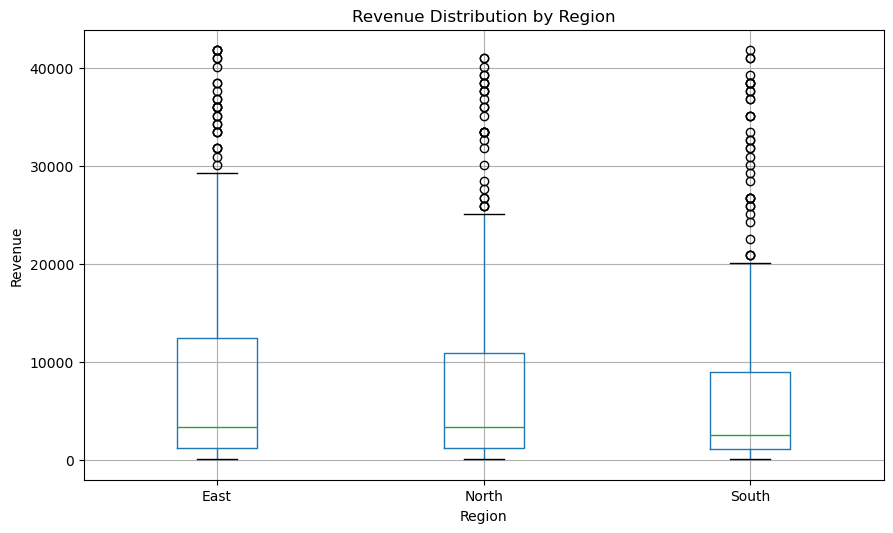

In [43]:
df.boxplot(column='Revenue', by='Region', figsize=(10, 6))
plt.title('Revenue Distribution by Region')
plt.suptitle('')
plt.ylabel('Revenue')
plt.show()

In [49]:
df = pd.read_excel('online_retail.xlsx')
df.dropna(subset=['CustomerID'], inplace=True) # Remove rows without a customer ID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]

In [51]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

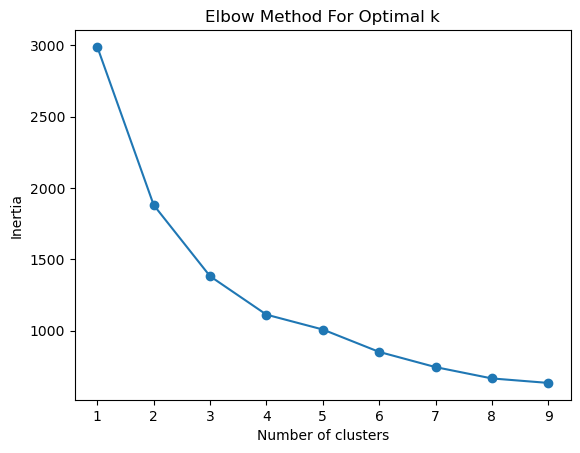

In [52]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [54]:
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_profile)

        Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          39.6       6.9   2351.4   307
1         179.7       3.3   1303.6   211
2          50.7       3.8   1356.5   350
3          44.8       6.8   5752.7   128


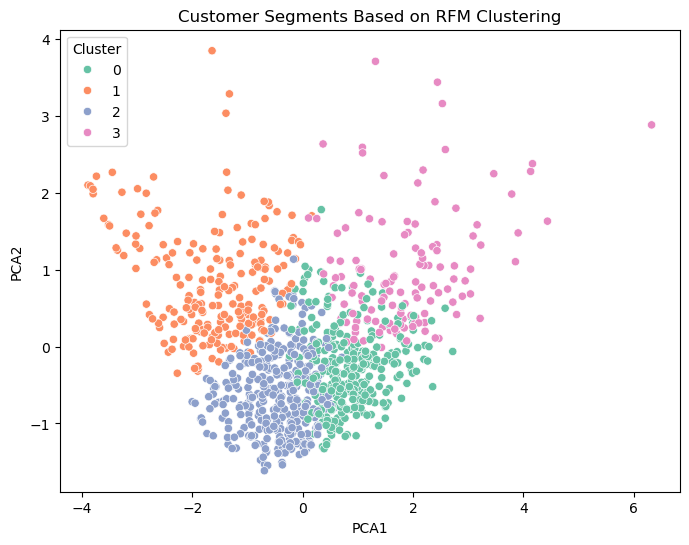

In [56]:
pca = PCA(2)
pca_components = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='Set2')
plt.title('Customer Segments Based on RFM Clustering')
plt.show()